In [9]:
# 파이썬 시각화 패키지 불러오기
import matplotlib.pyplot as plt
%matplotlib inline


# 사용자 운영체제 확인
import platform

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='NanumGothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

## 분산 분석(ANOVA)

선형회귀 분석의 결과를 측정하기 위한 방법으로 RSS(Residual Sum Square)를 이용할 수 있다.

그런데 여기서 RSS를 이용하면 다음과 같은 문제가 발생한다.

1. RSS는 데이터가 많으면 많을수록 큰 값을 가지게 된다.


2. $y$값의 단위가 달라지면 RSS 또한 달라진다.

따라서 상대적인 비교(모델과 모델)가 불가능하기 때문에 어떤 기준을 이용해 정규화가 필요하다.

`분산분석 (ANOVA : Analysis of Variance)`은 RSS만을 이용해 모델의 성능을 평가할 때 발생하는 문제를 보완하기 위한 방법이다. 

분산분석은 종속변수의 분산과 독립변수의 분산간의 관계를 이용해 선형회귀 모델의 성능을 평가한다.

따라서 RSS만을 이용해 성능을 평가할 때 발생하는 어떤 기준을 이용한 정규화 문제가 해결되어 **서로 다른 회귀분석 모델의 성능을 비교**할 수 있고 추가적으로 **독립변수가 카테고리 변수인 경우에도 각 카테고리 값에 따른 영향을 정량적으로 분석**할 수 있다.

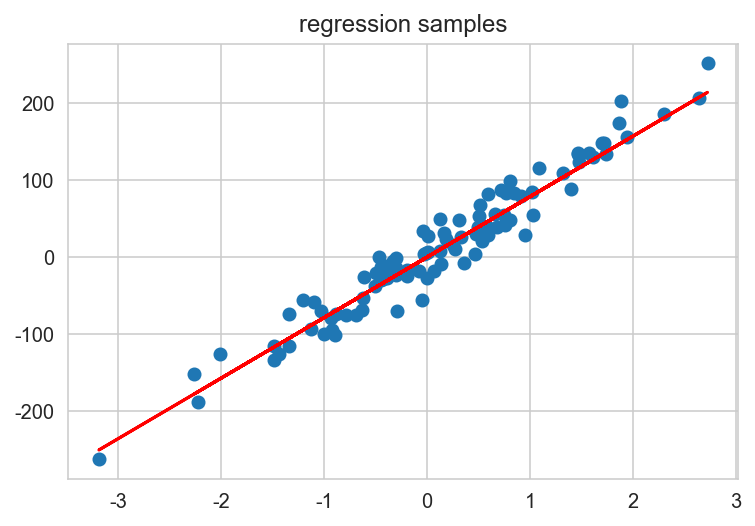

In [40]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, coef = True, noise=20)

plt.title('regression samples')
plt.scatter(X0, y)
plt.plot(X0, X0*coef, 'r-')

분산분석에는 `TSS, ESS, RSS`라는 개념이 사용된다.

**TSS는 종속변수값의 움직임의 범위**를 나타내는 개념으로 $y$값에 대한 분산으로 이해할 수 있다.

$$TSS = \sum_{i=1}^N(y_i - \bar{y})^2$$

**엄밀히 따지면 N으로 나누어주지 않아 분산은 아니다.**

TSS의 이해를 높기이 위한 방법으로 아래의 Joint plot을 사용할 수 있는데 $y$축의 히스토그램에서의 폭이 TSS라고 이해할 수 있다.

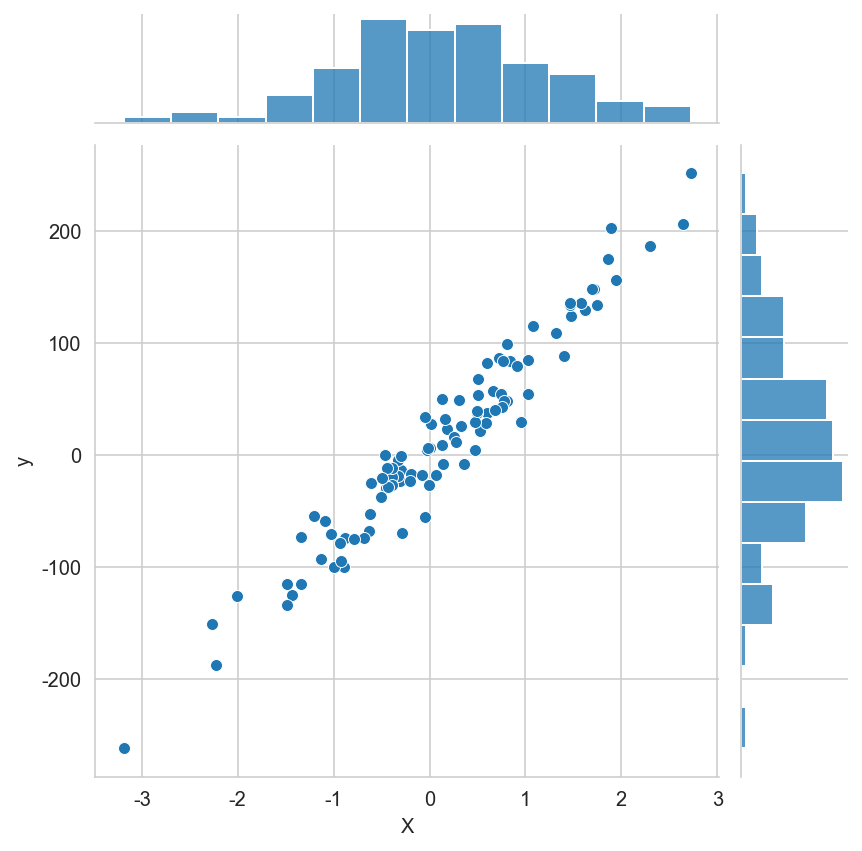

In [63]:
dfx = pd.DataFrame(X0)
dfy = pd.DataFrame(y)
df = pd.concat([dfx, dfy], axis=1)
df.columns = ['X','y']
sns.jointplot(data=df, x='X', y='y')

**ESS(explained sum of square)**는 회귀분석으로 예측한 $\hat{y}$의 분산을 의미한다.

$$ESS = \sum_{i=1}^N(\hat{y_i} - \bar{\hat{y}})^2$$

ESS의 경우 예측값에 대한 분산을 의미하므로 아래의 시각화 결과를 통해 TSS의 폭보다 더 좁아지는 것을 직관적으로 이해할 수 있다.

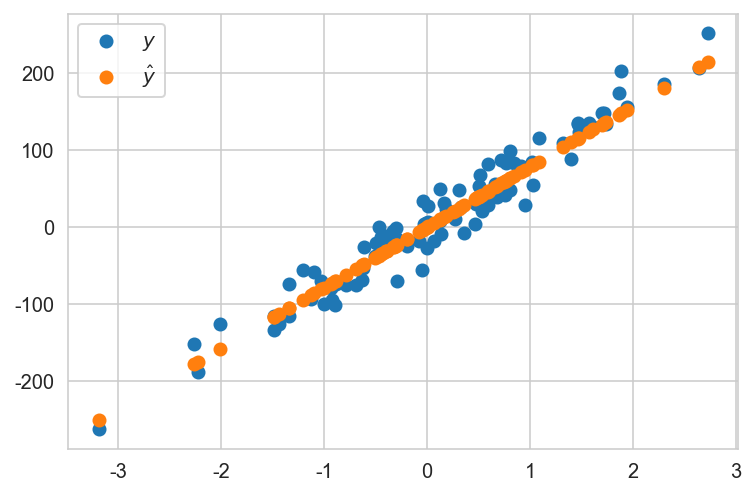

In [68]:
plt.scatter(X0, y, label='$y$')
plt.scatter(X0, X0*coef, label='$\hat{y}$')
plt.legend()
plt.show()

**RSS(residual sum of squares)**는 잔차 $e$의 분산을 의미한다.

$$RSS : \sum_{i=1}^N(y_i - \hat{y}_i)^2$$

TSS, ESS, RSS는 다음의 관계가 성립한다.

$$TSS = ESS + RSS$$

> 예측값의 분산은 $y$값의 분산보다 클 수 없다.

> 모형의 성능이 좋을수록 예측값의 분산은 $y$값의 분산과 크기가 비슷해진다.

## 회귀분석 결과의 TSS, ESS, RSS, R-squared

In [85]:
from sklearn.datasets import make_regression
import statsmodels.api as sm

X0, y, coef = make_regression(
    n_samples=100, n_features=1, noise=30, coef=True, random_state=0)
dfX0 = pd.DataFrame(X0, columns=["X"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["Y"])
df = pd.concat([dfX, dfy], axis=1)

model = sm.OLS.from_formula("Y ~ X", data=df)
result = model.fit()

In [87]:
print('TSS : ', result.uncentered_tss)
print('ESS : ', result.mse_model)
print('RSS : ', result.ssr)

TSS :  291345.7578983061
ESS :  188589.61349210917
RSS :  102754.33755137534


In [88]:
# TSS = ESS + RSS

print('ESS + RSS : ',result.mse_model + result.ssr)

ESS + RSS :  291343.9510434845


In [89]:
print('R squared : ', result.rsquared)

R squared :  0.6473091780922585


### TSS, ESS, RSS의 히스토그램 비교

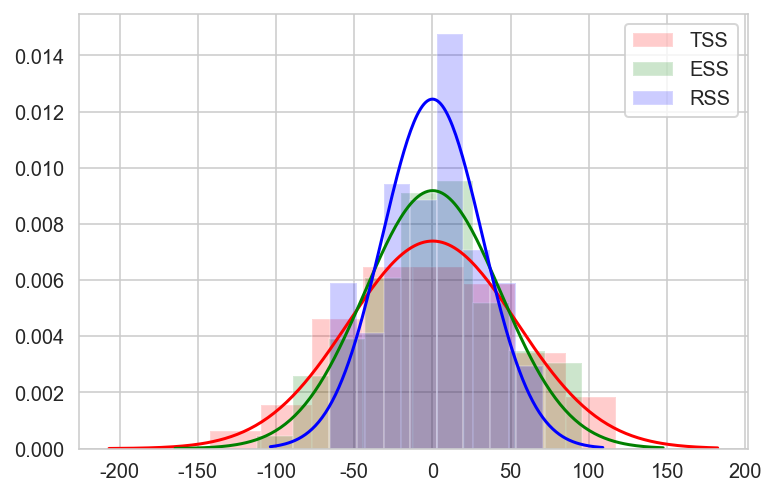

In [91]:
import scipy as sp
import scipy.stats

sns.distplot(y,
             kde=False, fit=sp.stats.norm, hist_kws={"color": "r", "alpha": 0.2}, fit_kws={"color": "r"},
             label="TSS")
sns.distplot(result.fittedvalues,
             kde=False, hist_kws={"color": "g", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "g"},
             label="ESS")
sns.distplot(result.resid,
             kde=False, hist_kws={"color": "b", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "b"},
             label="RSS")
plt.legend()
plt.show()

## 결정계수(Coefficient of Determination)

결정계수란 모형의 성능을 나타내는 값이다.

$$R^2 = 1 - \dfrac{RSS}{TSS} = \dfrac{ESS}{TSS}$$

RSS가 높다는 것은 예측값과 실제값의 오차가 크다는 것을 의미한다. 또한 RSS는 최대 TSS만큼의 값을 가질 수 있어 이 경우 $R^2$는 0이된다.

반대로 예측값과 실제값의 오차가 없을 경우는 $R^2$값은 1이 된다.

즉 $R^2$는 0과 1사이의 값을 가지며 1에 가까울수록 회귀분석의 결과가 완벽하다는 것을 의미한다.

결정계수가 $R^2$이라는 이름을 가지는 이유는 $y$와 $\hat{y}$의 상관계수 제곱과 같기 때문이다.

0.8045552672702222

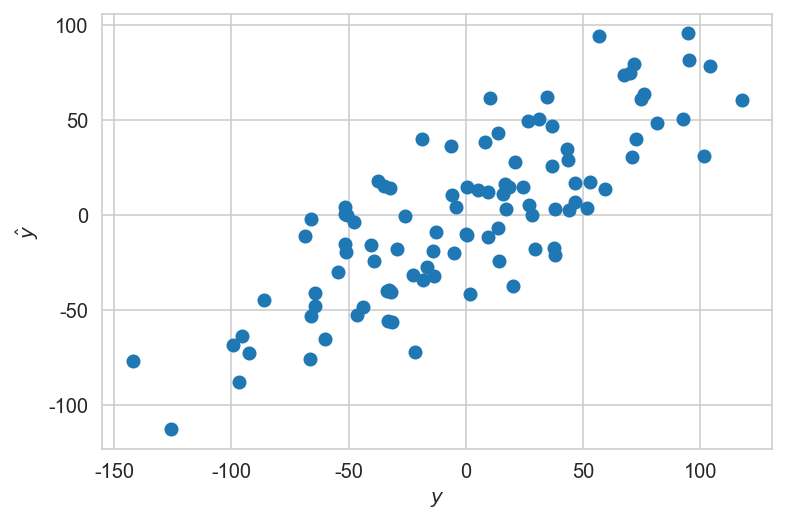

In [119]:
plt.scatter(y, result.fittedvalues)
plt.xlabel('$y$')
plt.ylabel('$\hat{y}$')
sp.stats.pearsonr(y, result.fittedvalues)[0]

In [121]:
# R^2

result.rsquared

0.6473091780922585

In [120]:
# 상관계수의 제곱

sp.stats.pearsonr(y, result.fittedvalues)[0] ** 2

0.6473091780922586